In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
import astropy.coordinates as coords

In [2]:
plt.rc('figure', dpi=120)

In [3]:
10.*u.earthMass/(0.02*u.solMass).to(u.earthMass)

<Quantity 0.0015017446744253966>

In [4]:
from destroyer import RockDerivative, GradientSpectra, Spectra

In [5]:
rd = RockDerivative()
dXHdm = rd.dXHdm_avg(0, 20)

In [6]:
g = GradientSpectra()

In [7]:
res = np.array([g.gradient[z]*dXHdm[i] for i, z in rd.df.Z[2:].iteritems()])
netres = res.sum(axis=0)

In [8]:
d = Spectra()

/Users/semyeong/projects/destroyer/destroyer/data.py:63: RuntimeWarning: invalid value encountered in less_equal
  bad_ivar = (~np.isfinite(self.ivar) | (self.ivar <= 0))


In [9]:
from numpy import ma

In [10]:
maskedspec = ma.array(d.spec, mask=d.mask, fill_value=0)
maskedivar = ma.array(d.ivar, mask=d.mask, fill_value=1)

In [28]:
print("number of wavelength pixels = {:d}".format(g.wave.size))

number of wavelength pixels = 3594


In [32]:
from matplotlib import ticker

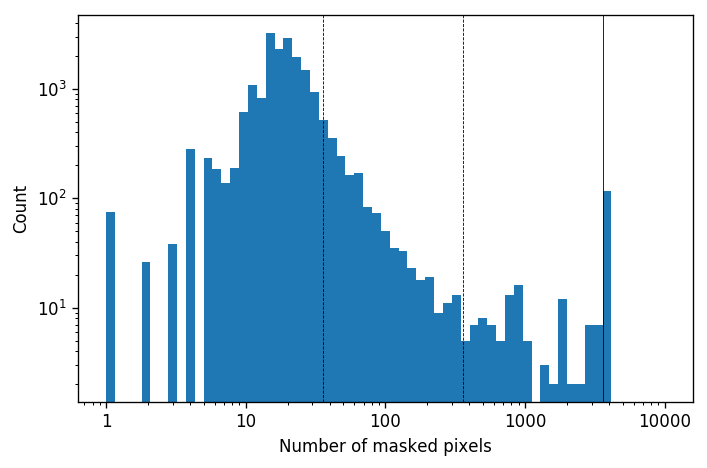

In [57]:
plt.hist(d.mask.sum(axis=1), np.logspace(0,4,64), log=True);
plt.xscale('log');
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter());
plt.axvline(g.wave.size, c='k', lw=.5,);
plt.axvline(g.wave.size*0.1, c='k', lw=.5, ls='dashed');
plt.axvline(g.wave.size*0.01, c='k', lw=.5, ls='dashed');
plt.xlabel("Number of masked pixels");
plt.ylabel("Count");
plt.tight_layout();
plt.savefig("plots/number_of_masked_pixels.png");

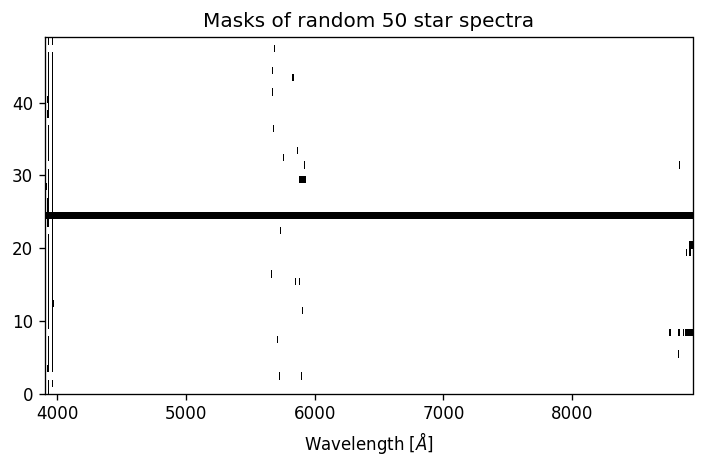

In [39]:
randidx = np.random.randint(0, high=d.spec.shape[0], size=50)
plt.pcolor(g.wave, np.arange(50), d.mask[randidx], cmap='gray_r');
plt.xlabel(r"Wavelength [$\AA$]")
plt.title("Masks of random 50 star spectra");
plt.tight_layout()
plt.savefig("plots/random_50_masks.png");

In [11]:
medspec = ma.median(maskedspec, axis=0)
diffspec = maskedspec - medspec

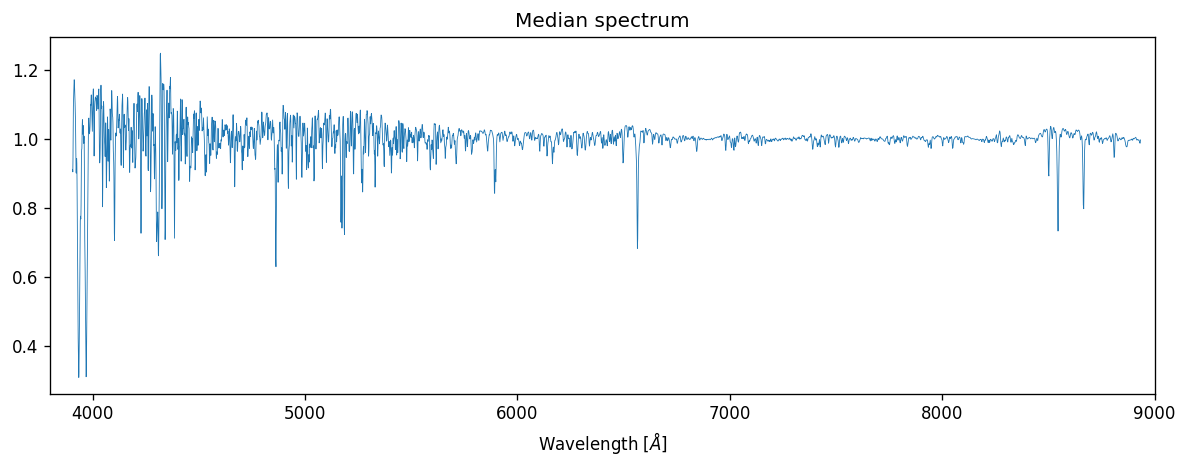

In [55]:
plt.figure(figsize=(10,4));
plt.xlim(3800,9000)
plt.plot(g.wave, medspec, lw=.5);
plt.xlabel("Wavelength [$\AA$]")
plt.title("Median spectrum");
plt.tight_layout()
plt.savefig("plots/median_spec.png");

In [59]:
beta = np.einsum('i,ji,ji->j', netres, diffspec.filled(), maskedivar.filled()) / np.einsum('i,ji->j', netres**2, maskedivar.filled())
model = np.einsum('i,j->ij', beta, netres)
chisq = ma.sum((diffspec-model)**2*maskedivar, axis=1)

In [60]:
np.percentile(beta, [0,.01,1,15,50,75,99,99.9,100])

array([ -4.62847139e+10,  -9.39911680e+03,  -5.00942029e+01,
        -5.10885347e+00,  -1.83101515e-01,   3.33249807e+00,
         1.25315226e+01,   2.50901506e+03,   8.83369961e+03])

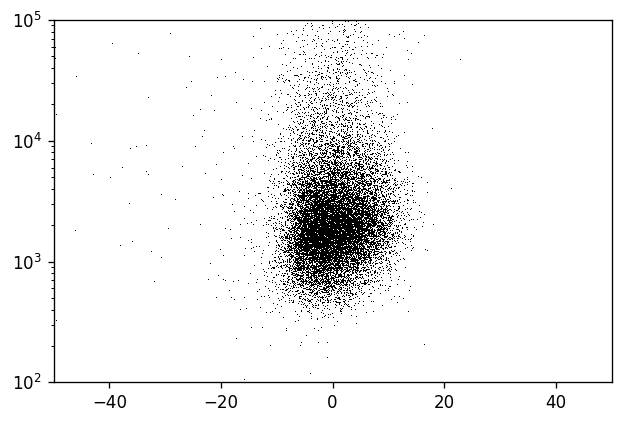

In [61]:
plt.plot(beta, chisq, 'k,')
plt.xlim(-50,50);
plt.ylim(100, 1e5);
plt.yscale('log')

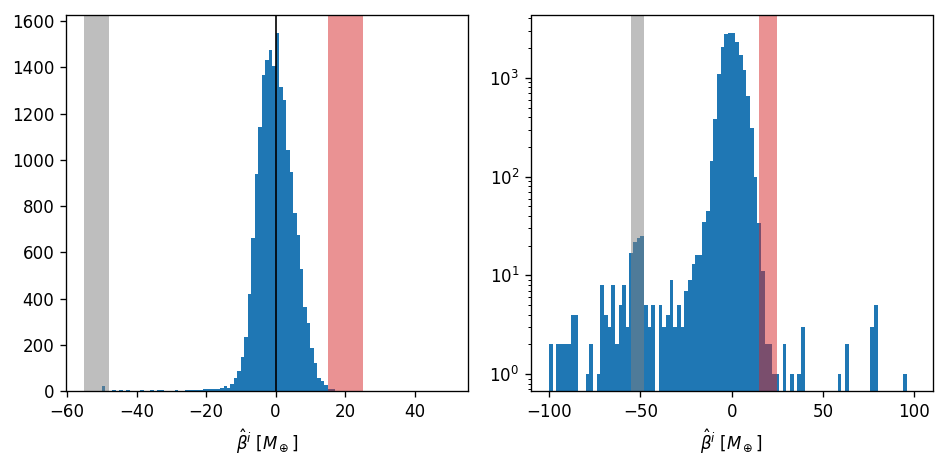

In [235]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].hist(beta, np.linspace(-50,50,101),);
# plt.axvspan(15,25,alpha=.5, color='gray');
ax[0].axvline(0, c='k', lw=1)
ax[0].set_xlabel(r"$\hat\beta^i$ [$M_\oplus$]")
ax[1].hist(beta, np.linspace(-100,100,101), log=True);
ax[1].set_xlabel(r"$\hat\beta^i$ [$M_\oplus$]");
fig.tight_layout()
for a in ax:
    plt.sca(a)
    plt.axvspan(-48,-55, alpha=.5, facecolor='tab:gray', );
    plt.axvspan(15,25, alpha=.5, facecolor='tab:red', );
fig.savefig("plots/hist_beta.png");

In [120]:
percspec = np.nanpercentile(d.spec, [0,0.1,1,2,10,50,90,98,99,99.9,100], axis=0)

In [153]:
outlier = (d.spec<percspec[1][None,:]) | (d.spec>percspec[-1][None,:])

/Users/semyeong/anaconda2/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/semyeong/anaconda2/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


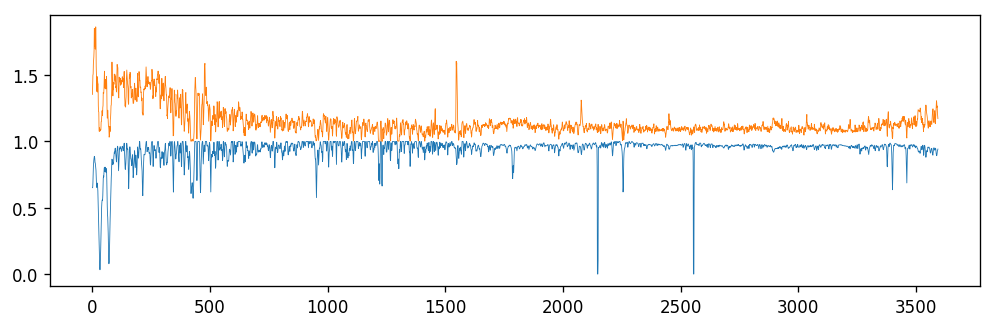

In [162]:
plt.figure(figsize=(10,3))
plt.plot(percspec[[2,-2]].T, lw=.5);
# plt.plot(d.spec[0]-percspec[2], lw=.5, c='k')
# plt.plot(outlier[0], c='r')
# plt.axhline(0)
# plt.ylim(-0.1,.6)

In [237]:
# wth = np.where((beta<-48) & (beta>-55))[0]
wth = np.where((beta>50) & (beta<100))[0]
wth

array([  118,   744,  1819,  3864, 11968, 12632, 14239, 17082, 17378,
       17701, 18363, 18593])

In [225]:
chisq[wth]/(~d.mask)[wth].sum(axis=1)

masked_array(data = [0.6851033310208319 0.5644212565654584 0.10911470400851786
 13.054692622447257 56.95019465126299 1.3617305962202324
 2.0549344982210216e+20 1.2409699624354467 0.36265997225288515
 324595.0816404634 0.6422420691442715 3.5213936209752337 17.79033618434951
 20.7314484025476 0.7300909155515628 0.3578374449220375 0.6178322149137633
 0.7216776694132573 0.5293196359287218 2104.171564446183 1.024907316871571
 0.5448137477778776 1.389922011110833 1.1066040288309136 0.8115368576428619
 0.5830774579944016],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False],
       fill_value = 1e+20)

In [236]:
!mkdir plots/beta_50_100

In [238]:
for j in wth:
    plt.figure(figsize=(10,4))
    plt.plot(g.wave, diffspec[j].T, lw=.5);
    # smoothed_signal = convolve(diffspec[j], Box1DKernel(5))
    # plt.plot(g.wave, smoothed_signal, lw=1)
    plt.plot(g.wave, model[j], lw=.5)
    plt.title(r"{:d} $\beta$={:.2f}".format(j,beta[j]));
    plt.tight_layout()
    plt.savefig("plots/beta_50_100/{:d}.png".format(j))
    plt.close()

In [22]:
from astropy.convolution import convolve, Box1DKernel

In [167]:
smoothed_signal = convolve(diffspec[j], Box1DKernel(5))

(-0.2, 0.2)

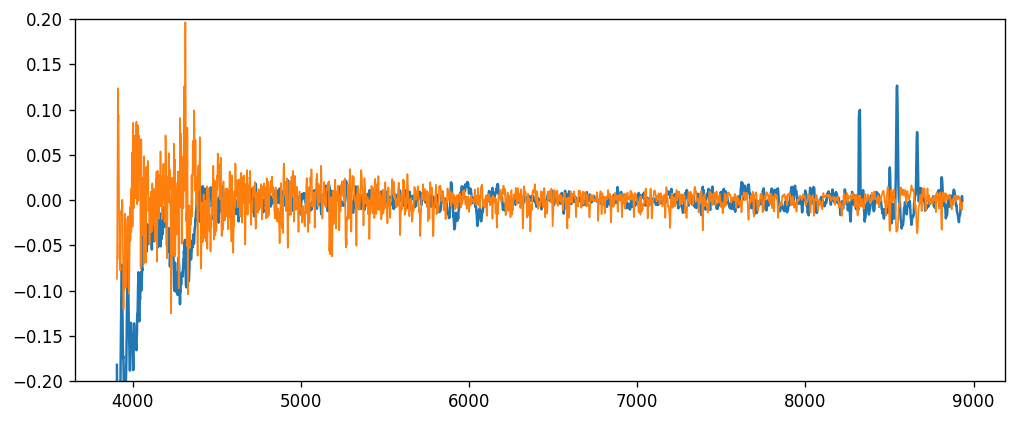

In [168]:
plt.figure(figsize=(10,4))
# plt.plot(wave, diffspec[j], lw=1)
plt.plot(wave, smoothed_signal)
plt.plot(wave, netres*s[j], lw=1)
# plt.plot(wave, diffspec[j] - netres*s[j] - 0.2, lw=.5)
# plt.xlim(3800,5000)
# plt.xlim(5000,6000)
# plt.xlim(8000,9000)
plt.ylim(-.2,.2)